In [2]:
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import seaborn as sb
from sklearn.pipeline import Pipeline

### Load Dataset

In [3]:
dataset = pd.read_csv('../dataset/recruitment_data.csv', sep=',', decimal='.')
features = list(dataset.columns.values)
target = features.pop(-1)
# dataset.nunique().sort_values() # Check number of unique values

features.remove('Gender')
features.remove('PreviousCompanies')
features.remove('DistanceFromCompany')
dataset

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0
...,...,...,...,...,...,...,...,...,...,...,...
1495,48,0,2,3,4,9.183783,66,3,80,3,1
1496,27,1,2,10,3,14.847731,43,97,7,2,0
1497,24,1,1,1,2,4.289911,31,91,58,1,1
1498,48,0,2,4,4,36.299263,9,37,44,2,1


### Correlation

In [4]:
corr = dataset.corr()
corr_target = corr['HiringDecision']
corr_target.sort_values(ascending = False)
corr_target

Age                    0.001850
Gender                -0.002249
EducationLevel         0.236710
ExperienceYears        0.122494
PreviousCompanies      0.044025
DistanceFromCompany   -0.016791
InterviewScore         0.146064
SkillScore             0.203668
PersonalityScore       0.169177
RecruitmentStrategy   -0.477552
HiringDecision         1.000000
Name: HiringDecision, dtype: float64

### Normalize dataset

In [5]:
X = dataset[features].to_numpy()
y = dataset[target]
random_seed = 11

# Split dataset in training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

# Normalize dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

### Verify data normalization

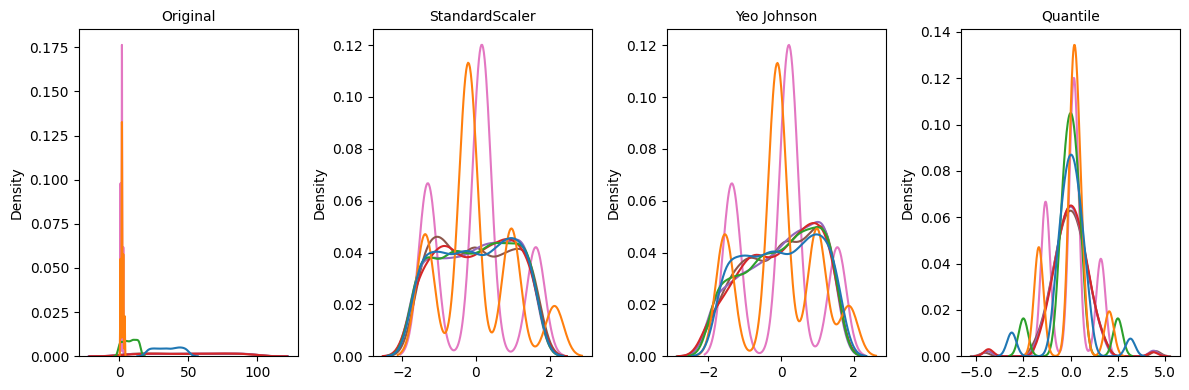

In [6]:
# Graph centered in 0 is better - less bias
# On our case, quantile transform is better

qTransformer = QuantileTransformer(output_distribution='normal')
pTransformer = PowerTransformer(method='yeo-johnson')

yeo_johnson = pTransformer.fit_transform(X_train)
yeo_johnson = scaler.fit_transform(yeo_johnson)

quantile = qTransformer.fit_transform(X_train)
quantile = scaler.fit_transform(quantile)

standard = scaler.fit_transform(X_train)

fig, axis = plt.subplots(1, 4, figsize=(12, 4))
sb.kdeplot(X_train, ax=axis[0], legend=False,)
axis[0].set_title('Original', size=10)

sb.kdeplot(standard, ax=axis[1], legend=False,)
axis[1].set_title('StandardScaler', size=10)

sb.kdeplot(yeo_johnson, ax=axis[2], legend=False)
axis[2].set_title('Yeo Johnson', size=10)

sb.kdeplot(quantile, ax=axis[3], legend=False)
axis[3].set_title('Quantile', size=10)

# Transform dataset again
X_train_scaled = qTransformer.fit_transform(X_train)
X_test_scaled = qTransformer.transform(X_test)

fig.tight_layout()

### Training params

In [7]:
max_neurons = [8,16]
f_activation = ['tanh'] # 'tanh', 'relu', 'sigmoid'
metric = 'accuracy' # 'Precision', 'Recall', 'Accuracy'
patience = 300
max_epochs = [5 * patience]
min_improvement = 0.01
adam_initial_learning_rate = [0.01, 0.001]
adam_learning_rate_decay = 0.99
loss = 'mse'
optimizer = 'adam'
max_cores = 4
validation_split = 0.3

keras.utils.set_random_seed(random_seed)
# Split data into kfolds
sk_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

### Model Function

In [8]:
# Function for model creation, needed for KerasClassifier
def create_model(neurons, activation, learning_rate=0.1):
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),  # Define input shape here
    tf.keras.layers.Dense(neurons, activation=activation),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output
    ])
    Adam(learning_rate=learning_rate, beta_1=adam_learning_rate_decay)
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
    return model

### Training preparation

In [9]:

# Create Keras Classifier
model = KerasClassifier(model=create_model, verbose=0)

param_grid = dict(
  epochs=max_epochs,
  model__neurons=max_neurons,
  model__activation=f_activation,
  optimizer=[optimizer],
  batch_size=[X_train_scaled.shape[0]],
  optimizer__learning_rate=adam_initial_learning_rate
)

# Setup Grid Search with cross validation
grid = GridSearchCV(
  estimator=model, 
  param_grid=param_grid, 
  cv=sk_folds, 
  verbose=3,
  n_jobs = max_cores,
  return_train_score=True
)

# Early stop callback
early_stopping = EarlyStopping(
  monitor='val_loss', 
  patience=patience, 
  restore_best_weights=True
)
early_stopping_metric = EarlyStopping(
  monitor = metric,
  mode='max',
  patience=patience,
  min_delta=min_improvement,
  restore_best_weights=True
)

### Training

In [10]:
print('TRAINING PROCEDURE STARTED...\n')

# Execute Grid Search
grid_result = grid.fit(
  X_train_scaled, 
  y_train, 
  callbacks=[early_stopping, early_stopping_metric], 
  validation_split=validation_split, 
  class_weight=class_weights_dict
)

# Best hyperparameter found
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Evaluate best model in test set
best_model = grid_result.best_estimator_.model_
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test)
print(f'Test set loss: {test_loss}, Test set accuracy: {test_accuracy}')

# Get best model in training
history = grid_result.best_estimator_.fit(
  X_train_scaled, 
  y_train, 
  validation_split=validation_split, 
  epochs=grid_result.best_params_['epochs'],
  verbose=0
)

TRAINING PROCEDURE STARTED...

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 4/5] END batch_size=1050, epochs=1500, model__activation=tanh, model__neurons=8, optimizer=adam, optimizer__learning_rate=0.01;, score=(train=0.862, test=0.805) total time=  35.5s
[CV 3/5] END batch_size=1050, epochs=1500, model__activation=tanh, model__neurons=8, optimizer=adam, optimizer__learning_rate=0.01;, score=(train=0.885, test=0.833) total time=  35.6s
[CV 1/5] END batch_size=1050, epochs=1500, model__activation=tanh, model__neurons=8, optimizer=adam, optimizer__learning_rate=0.01;, score=(train=0.861, test=0.824) total time=  35.6s
[CV 2/5] END batch_size=1050, epochs=1500, model__activation=tanh, model__neurons=8, optimizer=adam, optimizer__learning_rate=0.01;, score=(train=0.856, test=0.838) total time=  35.7s
[CV 5/5] END batch_size=1050, epochs=1500, model__activation=tanh, model__neurons=8, optimizer=adam, optimizer__learning_rate=0.01;, score=(train=0.867, test=0.776) total ti

[CV 5/5] END batch_size=1050, epochs=1500, model__activation=tanh, model__neurons=8, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.864, test=0.800) total time=  36.1s
[CV 4/5] END batch_size=1050, epochs=1500, model__activation=tanh, model__neurons=8, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.869, test=0.800) total time=  36.2s


[CV 1/5] END batch_size=1050, epochs=1500, model__activation=tanh, model__neurons=16, optimizer=adam, optimizer__learning_rate=0.01;, score=(train=0.890, test=0.857) total time=  36.3s
[CV 2/5] END batch_size=1050, epochs=1500, model__activation=tanh, model__neurons=16, optimizer=adam, optimizer__learning_rate=0.01;, score=(train=0.865, test=0.857) total time=  36.2s
[CV 4/5] END batch_size=1050, epochs=1500, model__activation=tanh, model__neurons=16, optimizer=adam, optimizer__learning_rate=0.01;, score=(train=0.881, test=0.819) total time=  34.0s
[CV 3/5] END batch_size=1050, epochs=1500, model__activation=tanh, model__neurons=16, optimizer=adam, optimizer__learning_rate=0.01;, score=(train=0.867, test=0.814) total time=  34.2s
[CV 1/5] END batch_size=1050, epochs=1500, model__activation=tanh, model__neurons=16, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.905, test=0.852) total time=  33.8s
[CV 5/5] END batch_size=1050, epochs=1500, model__activation=tanh, model__

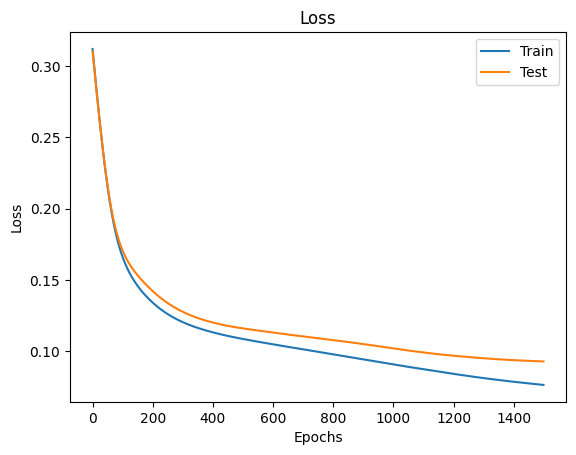

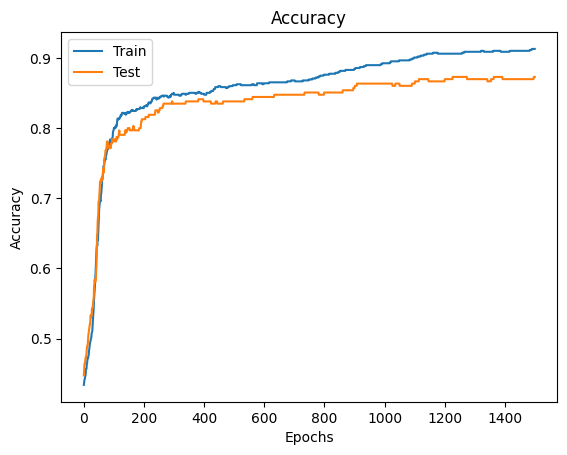

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


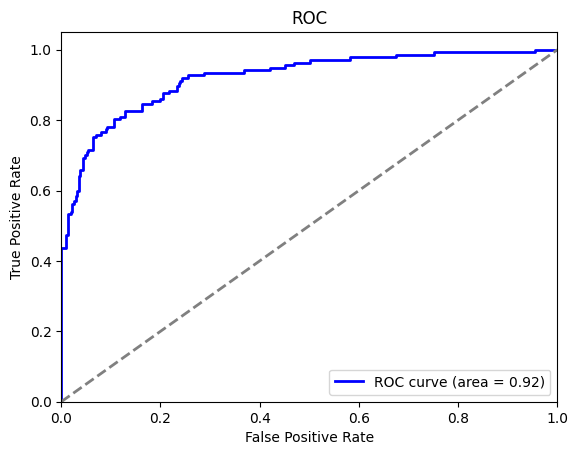

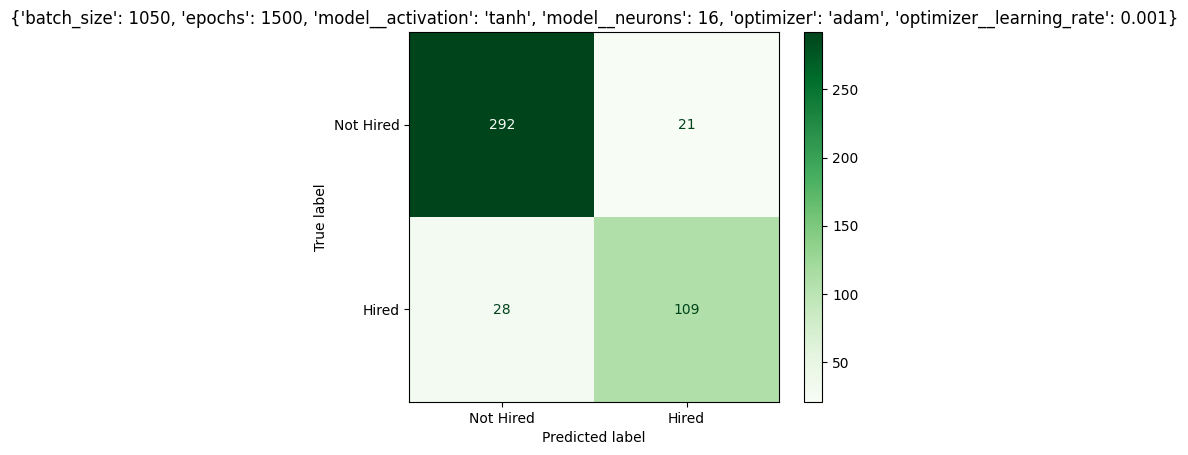

In [11]:
plt.plot(history.history_['loss'], label='Train')
plt.plot(history.history_['val_loss'], label='Test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history_['accuracy'], label='Train')
plt.plot(history.history_['val_accuracy'], label='Test')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Generate probability predictions
y_pred_proba = best_model.predict(X_test_scaled)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

# Plot confusion matrix
y_predict = grid_result.best_estimator_.predict(X_test_scaled)
fig = ConfusionMatrixDisplay.from_predictions(y_test, y_predict , display_labels=['Not Hired', 'Hired'], cmap='Greens')
plt.title(grid_result.best_params_)
plt.show()